In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('data/Bank Customer Churn Prediction.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [3]:
# 범주형 데이터 인코딩
df = pd.get_dummies(df, columns=['country'])
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)

# balance 0 값 처리  (balance_0 컬럼 추가 후 0값을 중앙값으로 대체)
df['balance_0'] = df['balance'].apply(lambda x: 1 if x == 0 else 0)
median_balance = df.loc[df['balance'] != 0, 'balance'].median()
df.loc[df['balance'] == 0, 'balance'] = median_balance

# products_number 2 이상 데이터 처리
# df['products_number'] = df['products_number'].apply(lambda x: 2 if x >= 2 else 1)

# PowerTransformer를 사용한 데이터 변환 (역효과)

# 'credit_score', 'age', 'balance', 'estimated_salary' 데이터 스케일링
from sklearn.preprocessing import StandardScaler
scale_columns = ['credit_score', 'age', 'balance', 'estimated_salary', ]
scaler = StandardScaler()
df = pd.concat([df.drop(scale_columns, axis=1), pd.DataFrame(scaler.fit_transform(df[scale_columns]), columns=scale_columns)], axis=1)

In [4]:
df.columns

Index(['customer_id', 'gender', 'tenure', 'products_number', 'credit_card',
       'active_member', 'churn', 'country_France', 'country_Germany',
       'country_Spain', 'balance_0', 'credit_score', 'age', 'balance',
       'estimated_salary'],
      dtype='object')

In [5]:
features = ['credit_score', 'gender', 'age', 'tenure', 'balance',
    'products_number', 'credit_card', 'active_member', 'estimated_salary',
    'country_France', 'country_Germany', 'country_Spain', 'balance_0']
target = 'churn'

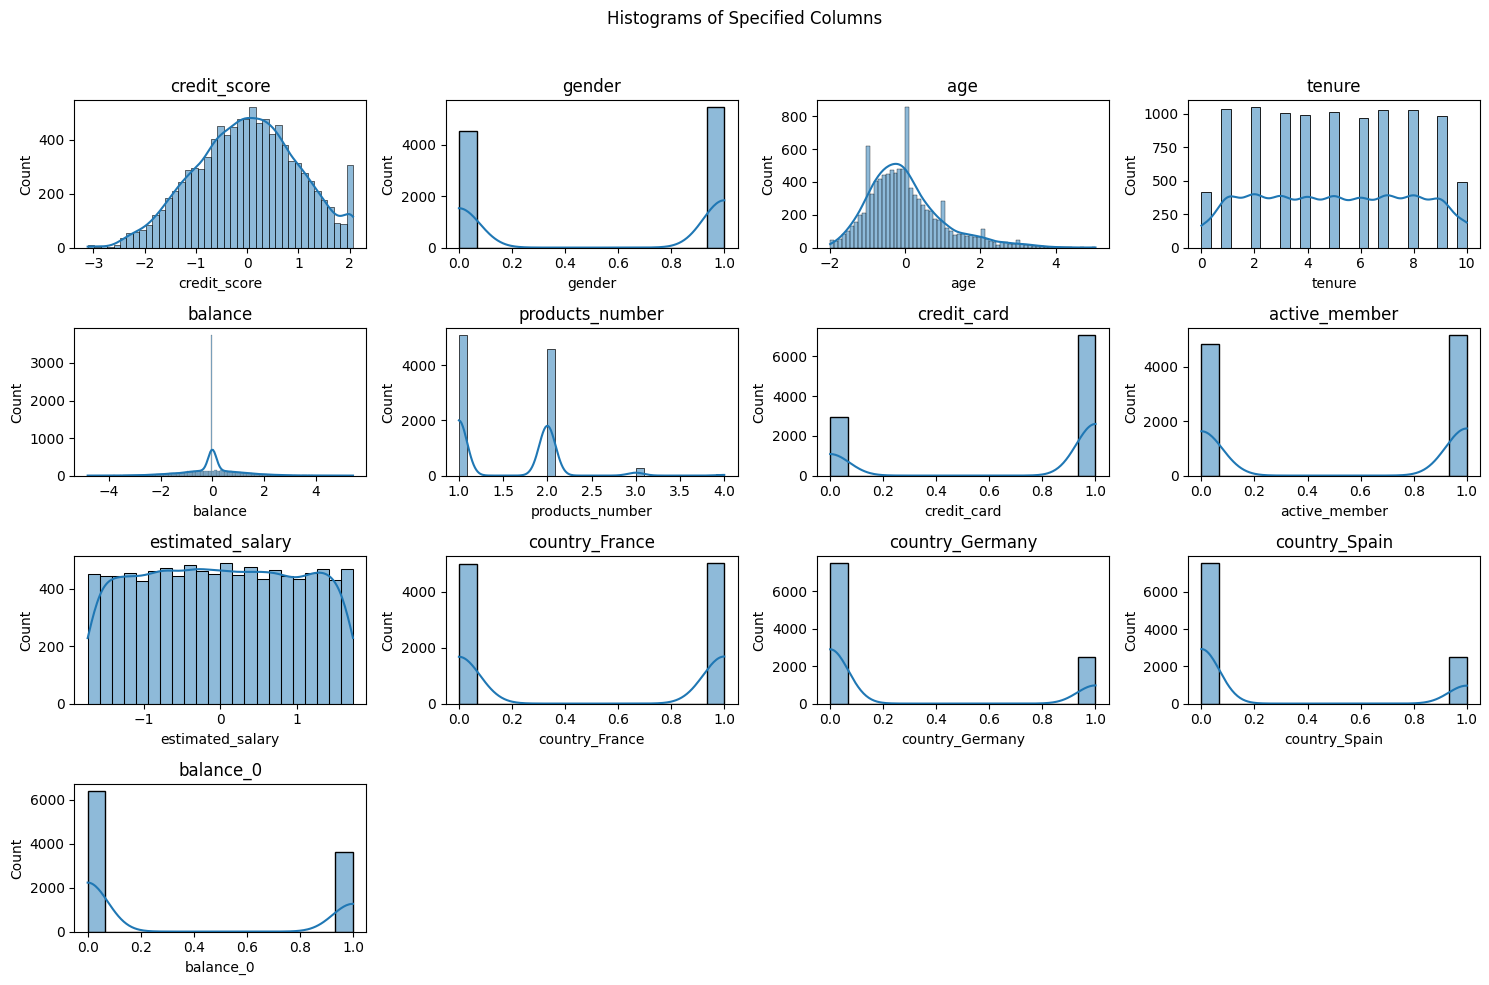

In [6]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(features, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[column], kde=True)
    plt.title(column)

plt.suptitle('Histograms of Specified Columns')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE를 사용한 오버샘플링
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
y_train.value_counts(normalize=True)

churn
0    0.5
1    0.5
Name: proportion, dtype: float64

In [8]:
# hpo
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

params = {
    'n_estimators': randint(10, 300),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
}

rf = RandomForestClassifier(random_state=42)
random_search_cv = RandomizedSearchCV(rf, param_distributions=params, cv=3, n_jobs=-1, random_state=42, n_iter=100)
random_search_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', random_search_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(random_search_cv.best_score_))


최적 하이퍼 파라미터:  {'max_depth': 17, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 263}
최고 예측 정확도: 0.8771


In [9]:
best_params = {
    'n_estimators': 263,
    'max_depth': 17,
    'min_samples_split': 2,
    'min_samples_leaf': 2
}

In [10]:
from utils import base_model, feature_importance

model = base_model(X_train, y_train, best_params)

Accuracy: 0.8808
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1303
           1       0.87      0.89      0.88      1240

    accuracy                           0.88      2543
   macro avg       0.88      0.88      0.88      2543
weighted avg       0.88      0.88      0.88      2543



In [11]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)

Accuracy: 0.8335
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1607
           1       0.57      0.65      0.61       393

    accuracy                           0.83      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.84      0.83      0.84      2000



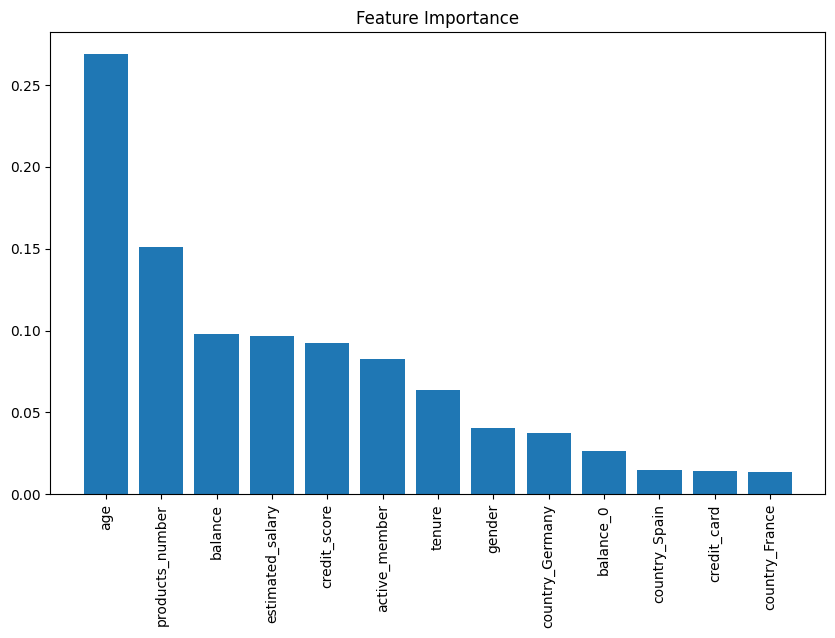

In [12]:
feature_importance(model, X_train)